In [1]:
import os
import sys
import pandas as pd
import numpy as np
import pickle

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns


from mcp_us_airline.utils import airport_utils
from mcp_us_airline.utils import constants
from mcp_us_airline.utils import demand_utils
from mcp_us_airline.utils import io_utils
from mcp_us_airline.utils import population_utils
from mcp_us_airline.utils import preprocess_utils


/tmp/ipykernel_3140560/3318551642.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def collect_mcp_results(data):
    
    field_mappings = {
        'demand': 1,
        'supply': (0, 1),
        'seats': 2,
        'distance': 3,
        'time': 4,
        'flights': 6
    }

    # data = io_utils.read_data_file(fname)
    results = {field: [] for field in field_mappings.keys()}

    for row in tqdm(data):
        for field, idx in field_mappings.items():
                if isinstance(idx, tuple):
                    value = row[idx[0]] / row[idx[1]]
                else:
                    value = row[idx]
                results[field].append(value)
    return results

def collect_itinerary_costs(data):
    '''
    collect the number of flights, distance, time, and seats for each itinerary
    '''
    itinerary_flights = []
    itinerary_distance = []
    itinerary_time = []
    itinerary_seats = []

    for row in data:
        itinerary_flights.append(len(row[-1]))
        itinerary_distance.append(row[3])
        itinerary_time.append(row[4])
        itinerary_seats.append(row[5])

    return itinerary_flights, itinerary_distance, itinerary_time, itinerary_seats

def collect_flight_carrier_counts(data, flight_info, normalize=False):
    flight_counts = {}
    carrier_counts = {}

    for row in data:
        list_of_flights = row[-1]
        set_of_carriers = set()
        
        for flight in list_of_flights:
            carrier = flight_info[flight]['carrier']
            set_of_carriers.add(carrier)
        
        number_of_carriers = len(set_of_carriers)
        number_of_flights = len(list_of_flights)

        if number_of_carriers not in carrier_counts:
            carrier_counts[number_of_carriers] = 1
        else:
            carrier_counts[number_of_carriers] += 1

        if number_of_flights not in flight_counts:
            flight_counts[number_of_flights] = 1
        else:
            flight_counts[number_of_flights] += 1

    if normalize:
        total_number_of_itineraries = len(data)
        flight_counts = {k: v / total_number_of_itineraries for k, v in flight_counts.items()}
        carrier_counts = {k: v / total_number_of_itineraries for k, v in carrier_counts.items()}

        
    return flight_counts, carrier_counts

In [29]:
RAW_DIR = constants.RAW_DIR
DERIVED_DIR = constants.DERIVED_DIR
RESULTS_DIR = constants.RESULTS_DIR
ONTIME_DIR = constants.ONTIME_DIR
DB1B_DIR = constants.DB1B_DIR
POPULATION_DIR = constants.POPULATION_DIR

YEAR = 2023
MONTH = 11
DATE = [22]
CARRIER = "all"

flights_dict = pickle.load(open(os.path.join(DERIVED_DIR, 'byproducts', f'ontime_dict_Y{YEAR}_M{MONTH}_D{DATE[0]}.pkl'), 'rb'))



In [30]:
cooperation_label = {
    'non_coop': 'no cooperation',
    'alliance': 'partial cooperation',
    'coop': 'full cooperation'
}

demand_type = 'gravity_A'
sample_idx = 1

# figure_file_name = os.path.join('../results/manuscript', 'figure3.pdf')  # for Y2023 M4 D18
figure_file_name = os.path.join('../results/manuscript',
                                f'SM-cooperative-system-{demand_type}-Y{YEAR}M{MONTH}D{DATE[0]}.pdf')


mcp_results = {}
mcp_stats = {}

for cost_type in ['distance', 'time', 'seats']:
    mcp_results[cost_type] = {}
    mcp_stats[cost_type] = {}
    
    for coop_type in cooperation_label.keys():
        print(f'collecting results for ({cost_type}, {coop_type})...')
        
        fname = os.path.join(RESULTS_DIR,f'Y{YEAR}M{MONTH}D{DATE[0]}', f'results_{demand_type}_{coop_type}_{cost_type}_r{sample_idx}.dat')
        raw_data = io_utils.read_data_file(fname)
        data = collect_mcp_results(raw_data)
        mcp_results[cost_type][coop_type] = data

        # collect stats from MCP itineraries
        mcp_stats[cost_type][coop_type] = {}
        itinerary_flights, itinerary_distance, itinerary_time, itinerary_seats = collect_itinerary_costs(raw_data)
        flight_counts, carrier_counts = collect_flight_carrier_counts(raw_data, flights_dict, normalize=True)
        mcp_stats[cost_type][coop_type] = {
            'flight_counts': flight_counts,
            'carrier_counts': carrier_counts,
            'itinerary_distance': itinerary_distance,
            'itinerary_flights': itinerary_flights,
            'itinerary_time': itinerary_time,
            'itinerary_seats': itinerary_seats
        }




collecting results for (distance, non_coop)...


100%|██████████| 2044661/2044661 [00:03<00:00, 590924.36it/s]


collecting results for (distance, alliance)...


100%|██████████| 2010798/2010798 [00:03<00:00, 545925.28it/s]


collecting results for (distance, coop)...


100%|██████████| 1965127/1965127 [00:03<00:00, 537547.64it/s]


collecting results for (time, non_coop)...


100%|██████████| 2035058/2035058 [00:03<00:00, 559077.09it/s]


collecting results for (time, alliance)...


100%|██████████| 1999692/1999692 [00:03<00:00, 550012.94it/s]


collecting results for (time, coop)...


100%|██████████| 1979639/1979639 [00:03<00:00, 572192.85it/s]


collecting results for (seats, non_coop)...


100%|██████████| 2028014/2028014 [00:03<00:00, 596279.17it/s]


collecting results for (seats, alliance)...


100%|██████████| 2032840/2032840 [00:03<00:00, 593920.05it/s]


collecting results for (seats, coop)...


100%|██████████| 2080093/2080093 [00:03<00:00, 577945.21it/s]


In [31]:
from matplotlib.lines import Line2D


def plot_figure3(figure_file_name, mcp_results, mcp_stats):
    cooperation_label = {
        'non_coop': 'no cooperation',
        'alliance': 'partial cooperation',
        'coop': 'full cooperation'
    }

    main_font_size=25
    legend_font_size=16
    lw=3.


    fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(24, 12))


    ### panel (a)

    ax[0][0].plot(mcp_results['distance']['non_coop']['demand'], 
                mcp_results['distance']['non_coop']['supply'], 
                ls='-', 
                lw=lw,
                c='tab:blue',
                label='distance, nc')

    ax[0][0].plot(mcp_results['distance']['alliance']['demand'], 
                mcp_results['distance']['alliance']['supply'], 
                ls='--',
                lw=lw,
                c='tab:blue',
                label='distance, pc')

    ax[0][0].plot(mcp_results['distance']['coop']['demand'], 
                mcp_results['distance']['coop']['supply'], 
                ls=':',
                lw=lw,
                c='tab:blue',
                label='distance, fc')


    ax[0][0].plot(mcp_results['time']['non_coop']['demand'], 
                mcp_results['time']['non_coop']['supply'], 
                ls='-', 
                lw=lw,
                c='tab:orange',
                label='time, nc')

    ax[0][0].plot(mcp_results['time']['alliance']['demand'], 
                mcp_results['time']['alliance']['supply'], 
                ls='--',
                lw=lw,
                c='tab:orange',
                label='time, pc')

    ax[0][0].plot(mcp_results['time']['coop']['demand'], 
                mcp_results['time']['coop']['supply'], 
                ls=':',
                lw=lw,
                c='tab:orange',
                label='time, fc')

    ax[0][0].plot(mcp_results['seats']['non_coop']['demand'], 
                mcp_results['seats']['non_coop']['supply'], 
                ls='-', 
                lw=lw,
                c='tab:purple',
                label='seats, nc')

    ax[0][0].plot(mcp_results['seats']['alliance']['demand'], 
                mcp_results['seats']['alliance']['supply'], 
                ls='--',
                lw=lw,
                c='tab:purple',
                label='seats, pc')

    ax[0][0].plot(mcp_results['seats']['coop']['demand'], 
                mcp_results['seats']['coop']['supply'], 
                ls=':',
                lw=lw,
                c='tab:purple',
                label='seats, fc')
                
    ax[0][0].set_xlabel('demanded itineraries', fontsize=main_font_size)
    ax[0][0].set_ylabel('supplied itineraries', fontsize=main_font_size)
    ax[0][0].tick_params('both', labelsize=main_font_size)
    # ax[0][0].legend(fontsize=legend_font_size, loc='lower left')
    ax[0][0].set_xscale('log')
    ax[0][0].set_xlim(5e3, 5e8)
    ax[0][0].set_ylim(-0.02, 1.02)

    # Create custom legend elements
    # First legend: Different metrics (colors)
    legend_metrics = [
        Line2D([0], [0], color='tab:blue', label='length', linestyle='-', lw=lw),
        Line2D([0], [0], color='tab:orange', label='duration', linestyle='-', lw=lw),
        Line2D([0], [0], color='tab:purple', label='seat avail.', linestyle='-', lw=lw)
    ]

    # Second legend: Different cooperation types (line styles)
    legend_coop = [
        Line2D([0], [0], color='black', label='no cooperation', linestyle='-', lw=lw),
        Line2D([0], [0], color='black', label='partial cooperation', linestyle='--', lw=lw),
        Line2D([0], [0], color='black', label='full cooperation', linestyle=':', lw=lw)
    ]

    # Add the first legend (metrics)
    first_legend = ax[0][0].legend(handles=legend_metrics, 
                                title='cost',
                                fontsize=legend_font_size, 
                                loc='lower left',
                                bbox_to_anchor=(0.0, 0.3),  # Adjust these values as needed
                                frameon=False)  # Remove the box
    # Keep the first legend
    ax[0][0].add_artist(first_legend)

    # Add the second legend (cooperation types)
    second_legend = ax[0][0].legend(handles=legend_coop, 
                                    title='cooperation',
                                    fontsize=legend_font_size, 
                                    loc='upper left',
                                    bbox_to_anchor=(0.0, 0.35),  # Adjust these values as needed
                                    frameon=False)  # Remove the box

    # Make title align left with the legend entries
    first_legend.get_title().set_ha('left')  # ha = horizontal alignment
    first_legend._legend_box.align = "left"   # Align the entire legend box
    first_legend.get_title().set_fontsize(legend_font_size + 3)  # Make title bigger than entries
    # first_legend.get_title().set_weight('bold')  # Optional: make title bold

    # Make title align left with the legend entries
    second_legend.get_title().set_ha('left')  # ha = horizontal alignment
    second_legend._legend_box.align = "left"   # Align the entire legend box
    second_legend.get_title().set_fontsize(legend_font_size + 3)  # Make title bigger than entries
    # second_legend.get_title().set_weight('bold')  # Optional: make title bold




    ### panel (b)

    ax[0][1].plot(mcp_results['distance']['non_coop']['demand'], 
                mcp_results['distance']['non_coop']['seats'], 
                ls='-', 
                lw=lw,
                c='tab:blue',
                label='distance, nc')

    ax[0][1].plot(mcp_results['distance']['alliance']['demand'], 
                mcp_results['distance']['alliance']['seats'], 
                ls='--',
                lw=lw,
                c='tab:blue',
                label='distance, pc')

    ax[0][1].plot(mcp_results['distance']['coop']['demand'], 
                mcp_results['distance']['coop']['seats'], 
                ls=':',
                lw=lw,
                c='tab:blue',
                label='distance, fc')

    ax[0][1].plot(mcp_results['time']['non_coop']['demand'], 
                mcp_results['time']['non_coop']['seats'], 
                ls='-', 
                lw=lw,
                c='tab:orange',
                label='time, nc')

    ax[0][1].plot(mcp_results['time']['alliance']['demand'], 
                mcp_results['time']['alliance']['seats'], 
                ls='--',
                lw=lw,
                c='tab:orange',
                label='time, pc')

    ax[0][1].plot(mcp_results['time']['coop']['demand'], 
                mcp_results['time']['coop']['seats'], 
                ls=':',
                lw=lw,
                c='tab:orange',
                label='time, fc') 

    ax[0][1].plot(mcp_results['seats']['non_coop']['demand'], 
                mcp_results['seats']['non_coop']['seats'], 
                ls='-', 
                lw=lw,
                c='tab:purple',
                label='seats, nc')

    ax[0][1].plot(mcp_results['seats']['alliance']['demand'], 
                mcp_results['seats']['alliance']['seats'], 
                ls='--',
                lw=lw,
                c='tab:purple',
                label='seats, pc')

    ax[0][1].plot(mcp_results['seats']['coop']['demand'], 
                mcp_results['seats']['coop']['seats'], 
                ls=':',
                lw=lw,
                c='tab:purple',
                label='seats, fc')

    ax[0][1].set_xlabel('demanded itineraries', fontsize=main_font_size)
    ax[0][1].set_ylabel('remaining seats', fontsize=main_font_size)
    ax[0][1].tick_params('both', labelsize=main_font_size)
    ax[0][1].set_xscale('log')
    ax[0][1].set_xlim(5e3, 5e8)
    ax[0][1].set_ylim(-0.02, 1.02)

                
                
    ### panel (c)
    # Find global min/max across all datasets
    min_dist = np.min([np.min(mcp_stats[metric][coop]['itinerary_distance']) 
                       for metric in ['distance', 'time', 'seats'] 
                       for coop in ['non_coop', 'alliance', 'coop']])
    max_dist = np.max([np.max(mcp_stats[metric][coop]['itinerary_distance']) 
                       for metric in ['distance', 'time', 'seats']
                       for coop in ['non_coop', 'alliance', 'coop']])
    
    bins = np.linspace(min_dist, max_dist, 30)
    
    sns.histplot(mcp_stats['distance']['non_coop']['itinerary_distance'], 
                stat='density',
                element='step',
                fill=False,
                color='tab:blue',
                ls='-',
                lw=lw,
                bins=bins, ax=ax[1][0])
    sns.histplot(mcp_stats['distance']['alliance']['itinerary_distance'], 
                stat='density',
                element='step',
                fill=False,
                color='tab:blue',
                ls='--',
                lw=lw,
                bins=bins, ax=ax[1][0])
    sns.histplot(mcp_stats['distance']['coop']['itinerary_distance'], 
                stat='density',
                element='step',
                fill=False,
                color='tab:blue',
                ls=':',
                lw=lw, bins=bins, ax=ax[1][0])

    sns.histplot(mcp_stats['time']['non_coop']['itinerary_distance'], 
                stat='density',
                element='step',
                fill=False,
                color='tab:orange',
                ls='-',
                lw=lw, bins=bins, ax=ax[1][0])
    sns.histplot(mcp_stats['time']['alliance']['itinerary_distance'], 
                stat='density',
                element='step',
                fill=False,
                color='tab:orange',
                ls='--',
                lw=lw, bins=bins, ax=ax[1][0])
    sns.histplot(mcp_stats['time']['coop']['itinerary_distance'], 
                stat='density',
                element='step',
                fill=False,
                color='tab:orange',
                ls=':',
                lw=lw, bins=bins, ax=ax[1][0])

    sns.histplot(mcp_stats['seats']['non_coop']['itinerary_distance'], 
                stat='density',
                element='step',
                fill=False,
                color='tab:purple',
                ls='-',
                lw=lw, bins=bins, ax=ax[1][0])
    sns.histplot(mcp_stats['seats']['alliance']['itinerary_distance'], 
                stat='density',
                element='step',
                fill=False,
                color='tab:purple',
                ls='--',
                lw=lw, bins=bins, ax=ax[1][0])
    sns.histplot(mcp_stats['seats']['coop']['itinerary_distance'], 
                stat='density',
                element='step',
                fill=False,
                color='tab:purple',
                ls=':',
                lw=lw, bins=bins, ax=ax[1][0])

    ax[1][0].set_xlabel("itinerary length", fontsize=main_font_size)
    ax[1][0].set_ylabel("probability distribution", fontsize=main_font_size)
    ax[1][0].tick_params('both', labelsize=main_font_size)
    ax[1][0].set_xlim(0, 10000)
    ax[1][0].set_ylim(0, 0.0006)


    ### panel (d)
    min_dist = np.min([np.min(mcp_stats[metric][coop]['itinerary_time']) 
                       for metric in ['distance', 'time', 'seats'] 
                       for coop in ['non_coop', 'alliance', 'coop']])
    max_dist = np.max([np.max(mcp_stats[metric][coop]['itinerary_time']) 
                       for metric in ['distance', 'time', 'seats']
                       for coop in ['non_coop', 'alliance', 'coop']])
    
    bins = np.linspace(min_dist, max_dist, 30)
    sns.histplot(mcp_stats['distance']['non_coop']['itinerary_time'], 
                stat='density',
                element='step',
                fill=False,
                color='tab:blue',
                ls='-',
                lw=lw,
                bins=bins, ax=ax[1][1])
    sns.histplot(mcp_stats['distance']['alliance']['itinerary_time'], 
                stat='density',
                element='step',
                fill=False,
                color='tab:blue',
                ls='--',
                lw=lw,
                bins=bins, ax=ax[1][1])
    sns.histplot(mcp_stats['distance']['coop']['itinerary_time'], 
                stat='density',
                element='step',
                fill=False,
                color='tab:blue',
                ls=':',
                lw=lw, bins=bins, ax=ax[1][1])

    sns.histplot(mcp_stats['time']['non_coop']['itinerary_time'], 
                stat='density',
                element='step',
                fill=False,
                color='tab:orange',
                ls='-',
                lw=lw, bins=bins, ax=ax[1][1])
    sns.histplot(mcp_stats['time']['alliance']['itinerary_time'], 
                stat='density',
                element='step',
                fill=False,
                color='tab:orange',
                ls='--',
                lw=lw, bins=bins, ax=ax[1][1])
    sns.histplot(mcp_stats['time']['coop']['itinerary_time'], 
                stat='density',
                element='step',
                fill=False,
                color='tab:orange',
                ls=':',
                lw=lw, bins=bins, ax=ax[1][1])

    sns.histplot(mcp_stats['seats']['non_coop']['itinerary_time'], 
                stat='density',
                element='step',
                fill=False,
                color='tab:purple',
                ls='-',
                lw=lw, bins=bins, ax=ax[1][1])
    sns.histplot(mcp_stats['seats']['alliance']['itinerary_time'], 
                stat='density',
                element='step',
                fill=False,
                color='tab:purple',
                ls='--',
                lw=lw, bins=bins, ax=ax[1][1])
    sns.histplot(mcp_stats['seats']['coop']['itinerary_time'], 
                stat='density',
                element='step',
                fill=False,
                color='tab:purple',
                ls=':',
                lw=lw, bins=bins, ax=ax[1][1])

    ax[1][1].set_xlabel("itinerary duration", fontsize=main_font_size)
    ax[1][1].set_ylabel("probability distribution", fontsize=main_font_size)
    ax[1][1].tick_params('both', labelsize=main_font_size)
    ax[1][1].set_xlim(0, 1500)
    ax[1][1].set_ylim(0, 0.006)



    ### panel (e)
    # Plot for distance optimization
    x_vals = [1, 2, 3]
    x_positions = np.arange(len(x_vals))
    bar_width = 0.08  # Made thinner to fit 9 bars without overlap

    # Plot for distance optimization
    y_vals_dist_nc = [mcp_stats['distance']['non_coop']['carrier_counts'].get(i, 0) for i in x_vals]
    y_vals_dist_al = [mcp_stats['distance']['alliance']['carrier_counts'].get(i, 0) for i in x_vals]
    y_vals_dist_co = [mcp_stats['distance']['coop']['carrier_counts'].get(i, 0) for i in x_vals]

    ax[0][2].bar(x_positions - 4*bar_width, y_vals_dist_nc, bar_width,
                color='tab:blue', alpha=0.9)
    ax[0][2].bar(x_positions - 3*bar_width, y_vals_dist_al, bar_width,
                color='tab:blue', alpha=0.6)
    ax[0][2].bar(x_positions - 2*bar_width, y_vals_dist_co, bar_width,
                color='tab:blue', alpha=0.3)

    # Plot for time optimization
    y_vals_time_nc = [mcp_stats['time']['non_coop']['carrier_counts'].get(i, 0) for i in x_vals]
    y_vals_time_al = [mcp_stats['time']['alliance']['carrier_counts'].get(i, 0) for i in x_vals]
    y_vals_time_co = [mcp_stats['time']['coop']['carrier_counts'].get(i, 0) for i in x_vals]

    ax[0][2].bar(x_positions - bar_width, y_vals_time_nc, bar_width,
                color='tab:orange', alpha=0.9)
    ax[0][2].bar(x_positions, y_vals_time_al, bar_width,
                color='tab:orange', alpha=0.6)
    ax[0][2].bar(x_positions + bar_width, y_vals_time_co, bar_width,
                color='tab:orange', alpha=0.3)

    # Plot for seats optimization
    y_vals_seats_nc = [mcp_stats['seats']['non_coop']['carrier_counts'].get(i, 0) for i in x_vals]
    y_vals_seats_al = [mcp_stats['seats']['alliance']['carrier_counts'].get(i, 0) for i in x_vals]
    y_vals_seats_co = [mcp_stats['seats']['coop']['carrier_counts'].get(i, 0) for i in x_vals]

    ax[0][2].bar(x_positions + 2*bar_width, y_vals_seats_nc, bar_width,
                color='tab:purple', alpha=0.9)
    ax[0][2].bar(x_positions + 3*bar_width, y_vals_seats_al, bar_width,
                color='tab:purple', alpha=0.6)
    ax[0][2].bar(x_positions + 4*bar_width, y_vals_seats_co, bar_width,
                color='tab:purple', alpha=0.3)

    ax[0][2].set_xticks(x_positions)
    ax[0][2].set_xticklabels(x_vals)
    ax[0][2].set_xlabel("number of carriers", fontsize=main_font_size)
    ax[0][2].set_ylabel("probability distribution", fontsize=main_font_size)
    ax[0][2].tick_params('both', labelsize=main_font_size)
    ax[0][2].set_ylim(0, 1.02)

    legend_metrics = [
        Line2D([0], [0], color='tab:blue', label='length', linestyle='-', lw=lw*2),
        Line2D([0], [0], color='tab:orange', label='duration', linestyle='-', lw=lw*2),
        Line2D([0], [0], color='tab:purple', label='seat avail.', linestyle='-', lw=lw*2)
    ]

    # Second legend: Different cooperation types (line styles)
    legend_coop = [
        Line2D([0], [0], color='gray', label='no cooperation', linestyle='-', lw=lw*2, alpha=0.9),
        Line2D([0], [0], color='gray', label='partial cooperation', linestyle='-', lw=lw*2, alpha=0.6),
        Line2D([0], [0], color='gray', label='full cooperation', linestyle='-', lw=lw*2, alpha=0.3)
    ]

    # Add the first legend (metrics)
    first_legend = ax[0][2].legend(handles=legend_metrics, 
                                title='cost',
                                fontsize=legend_font_size, 
                                loc='lower left',
                                bbox_to_anchor=(0.3, 0.6),  # Adjust these values as needed
                                frameon=False)  # Remove the box
    # Keep the first legend
    ax[0][2].add_artist(first_legend)

    # Add the second legend (cooperation types)
    second_legend = ax[0][2].legend(handles=legend_coop, 
                                    title='cooperation',
                                    fontsize=legend_font_size, 
                                    loc='upper left',
                                    bbox_to_anchor=(0.3, 0.65),  # Adjust these values as needed
                                    frameon=False)  # Remove the box

    # Make title align left with the legend entries
    first_legend.get_title().set_ha('left')  # ha = horizontal alignment
    first_legend._legend_box.align = "left"   # Align the entire legend box
    first_legend.get_title().set_fontsize(legend_font_size + 3)  # Make title bigger than entries
    # first_legend.get_title().set_weight('bold')  # Optional: make title bold

    # Make title align left with the legend entries
    second_legend.get_title().set_ha('left')  # ha = horizontal alignment
    second_legend._legend_box.align = "left"   # Align the entire legend box
    second_legend.get_title().set_fontsize(legend_font_size + 3)  # Make title bigger than entries






    ### panel (f)
    # Plot for distance optimization
    x_vals = [1, 2, 3]
    x_positions = np.arange(len(x_vals))
    bar_width = 0.08  # Made thinner to fit 9 bars without overlap

    # Plot for distance optimization
    y_vals_dist_nc = [mcp_stats['distance']['non_coop']['flight_counts'].get(i, 0) for i in x_vals]
    y_vals_dist_al = [mcp_stats['distance']['alliance']['flight_counts'].get(i, 0) for i in x_vals]
    y_vals_dist_co = [mcp_stats['distance']['coop']['flight_counts'].get(i, 0) for i in x_vals]

    ax[1][2].bar(x_positions - 4*bar_width, y_vals_dist_nc, bar_width,
                color='tab:blue', alpha=0.9)
    ax[1][2].bar(x_positions - 3*bar_width, y_vals_dist_al, bar_width,
                color='tab:blue', alpha=0.6)
    ax[1][2].bar(x_positions - 2*bar_width, y_vals_dist_co, bar_width,
                color='tab:blue', alpha=0.3)

    # Plot for time optimization
    y_vals_time_nc = [mcp_stats['time']['non_coop']['flight_counts'].get(i, 0) for i in x_vals]
    y_vals_time_al = [mcp_stats['time']['alliance']['flight_counts'].get(i, 0) for i in x_vals]
    y_vals_time_co = [mcp_stats['time']['coop']['flight_counts'].get(i, 0) for i in x_vals]

    ax[1][2].bar(x_positions - bar_width, y_vals_time_nc, bar_width,
                color='tab:orange', alpha=0.9)
    ax[1][2].bar(x_positions, y_vals_time_al, bar_width,
                color='tab:orange', alpha=0.6)
    ax[1][2].bar(x_positions + bar_width, y_vals_time_co, bar_width,
                color='tab:orange', alpha=0.3)

    # Plot for seats optimization
    y_vals_seats_nc = [mcp_stats['seats']['non_coop']['flight_counts'].get(i, 0) for i in x_vals]
    y_vals_seats_al = [mcp_stats['seats']['alliance']['flight_counts'].get(i, 0) for i in x_vals]
    y_vals_seats_co = [mcp_stats['seats']['coop']['flight_counts'].get(i, 0) for i in x_vals]

    ax[1][2].bar(x_positions + 2*bar_width, y_vals_seats_nc, bar_width,
                color='tab:purple', alpha=0.9)
    ax[1][2].bar(x_positions + 3*bar_width, y_vals_seats_al, bar_width,
                color='tab:purple', alpha=0.6)
    ax[1][2].bar(x_positions + 4*bar_width, y_vals_seats_co, bar_width,
                color='tab:purple', alpha=0.3)

    ax[1][2].set_xticks(x_positions)
    ax[1][2].set_xticklabels(x_vals)
    ax[1][2].set_xlabel("number of flights", fontsize=main_font_size)
    ax[1][2].set_ylabel("probability distribution", fontsize=main_font_size)
    ax[1][2].tick_params('both', labelsize=main_font_size)
    ax[1][2].set_ylim(0, 1.02)

    ##### misc. #####
    panel_fontsize=30
    ax[0][0].text(0.9, 0.88, '(a)', 
                transform=ax[0][0].transAxes, 
                fontsize=panel_fontsize, ha='center', va='center')
    ax[0][1].text(0.9, 0.88, '(b)', 
                transform=ax[0][1].transAxes, 
                fontsize=panel_fontsize, ha='center', va='center')
    ax[1][0].text(0.9, 0.88, '(c)', 
                transform=ax[1][0].transAxes, 
                fontsize=panel_fontsize, ha='center', va='center')
    ax[1][1].text(0.9, 0.88, '(d)', 
                transform=ax[1][1].transAxes, 
                fontsize=panel_fontsize, ha='center', va='center')

    ax[0][2].text(0.9, 0.88, '(e)', transform=ax[0][2].transAxes, fontsize=panel_fontsize, ha='center', va='center')
    ax[1][2].text(0.9, 0.88, '(f)', transform=ax[1][2].transAxes, fontsize=panel_fontsize, ha='center', va='center')



    plt.tight_layout()
    plt.savefig(figure_file_name, bbox_inches='tight', format='pdf')
    plt.show()

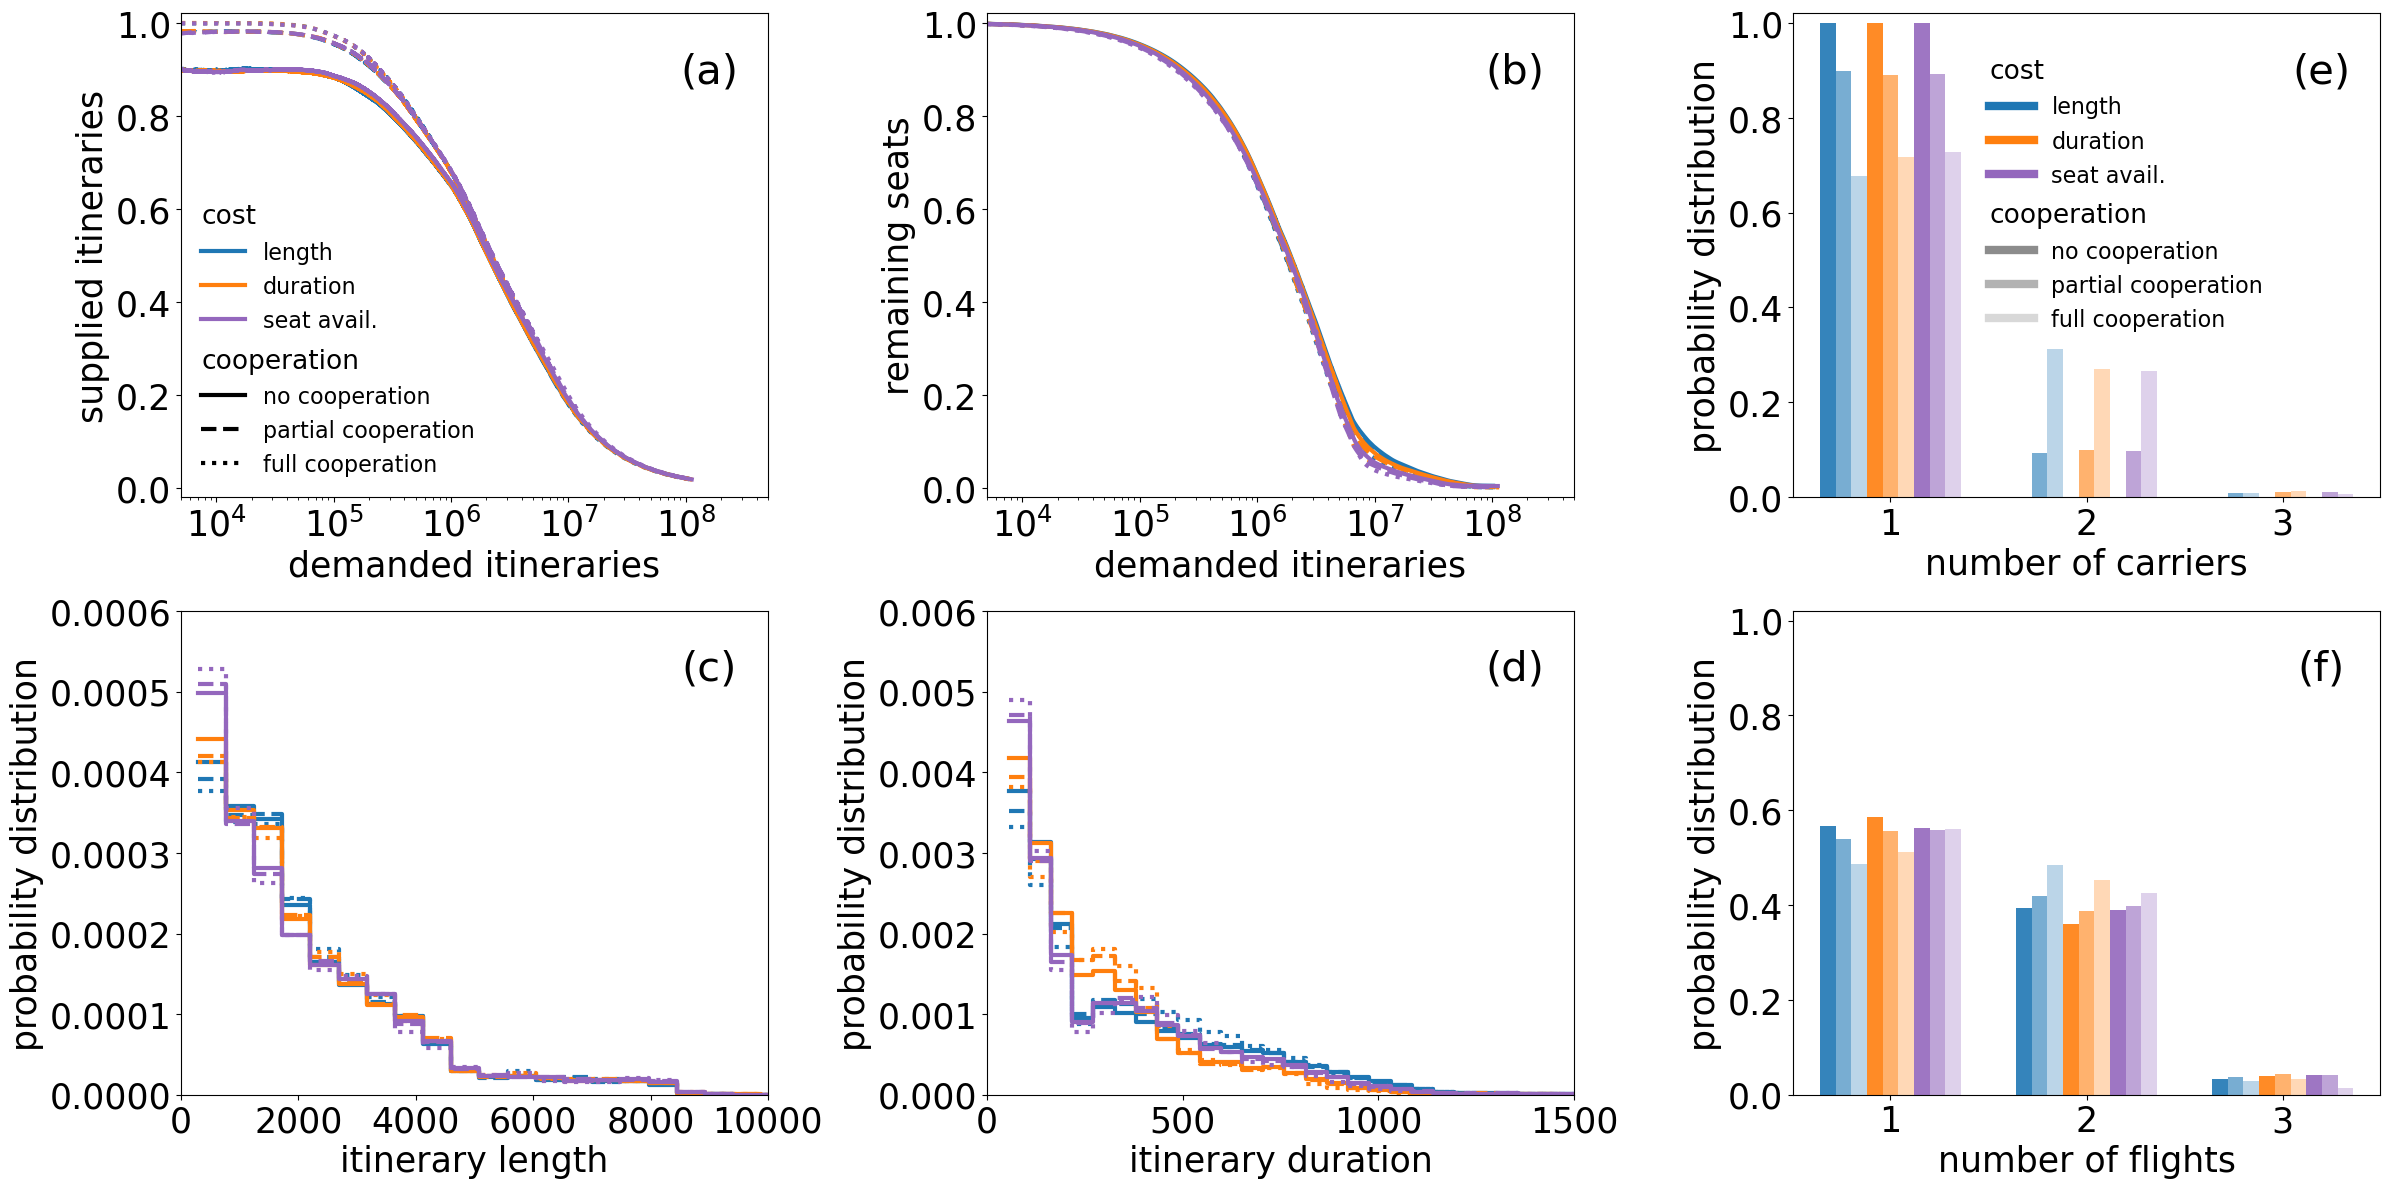

../results/manuscript/SM-cooperative-system-gravity_A-Y2023M11D22.pdf


In [32]:
plot_figure3(figure_file_name, mcp_results, mcp_stats)
print(figure_file_name)